# Import

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import matplotlib.pyplot as plt
from PIL import Image
import cv2
%matplotlib inline

In [2]:
TrainImg_DIR = '../datasets/train_data/train_data/'
TestImg_DIR = '../datasets/test_data/test_data/'

train_csv = pd.read_csv('../datasets/train.csv')
train_csv = train_csv.sort_values(by=['id'])

sampleSubmit_csv = pd.read_csv('../datasets/sample_submission.csv', header=None)
sampleSubmit_csv.columns = [['id', 'preds']]

x_train = np.array(train_csv['id'])
t_train = np.array(train_csv['target'])
x_test = np.array(sampleSubmit_csv['id']).flatten()

In [31]:
height = 224
width = 224
lr = 1e-5
n_epochs = 500
batch_size = 20
val_ratio = 0.2

In [4]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [5]:
#各チャンネルごとの平均値と標準偏差を求める
#mean, std = get_mean_and_std(dataloader_test)
#print(mean)
#print(std)

In [6]:
class train_dataset(torch.utils.data.Dataset):
  def __init__(self, x_train, t_train, transform):
    self.x_train = x_train
    self.t_train = t_train.astype("int32")
    self.transform = transform

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self, idx):
    image = Image.open(TrainImg_DIR+self.x_train[idx])
    data = torch.tensor(np.array(image), dtype=torch.float)
    data = torch.transpose(data, 0, 2)
    data = torch.transpose(data, 1, 2)
    label = torch.tensor(self.t_train[idx], dtype=torch.float)
    if self.transform:
      data = self.transform(data)
      return data, label
  
class test_dataset(torch.utils.data.Dataset):
  def __init__(self, x_test, transform):
    self.x_test = x_test
    self.transform = transform
  
  def __len__(self):
    return len(self.x_test)
  
  def __getitem__(self, idx):
    image = Image.open(TestImg_DIR+self.x_test[idx])
    data = torch.tensor(np.array(image), dtype=torch.float)
    data = torch.transpose(data, 0, 2)
    data = torch.transpose(data, 1, 2)
    if self.transform:
      data = self.transform(data)
      return data

In [7]:
#前処理の定義
transform_train = transforms.Compose([])
transform_test = transforms.Compose([])

transform_train = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=10, expand=True),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize((0.4834, 0.4834, 0.4834),
                             (0.2892, 0.2892, 0.2892)),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize((0.4834, 0.4834, 0.4834),
                             (0.2892, 0.2892, 0.2892)),
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


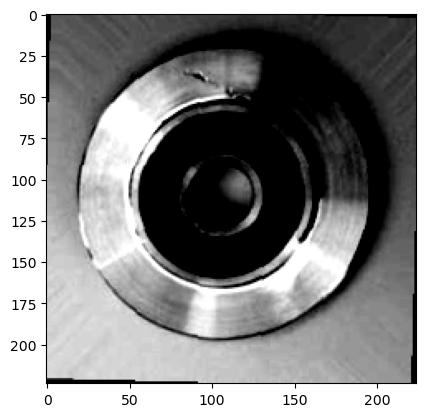

In [12]:
# 前処理した画像の例
img_path = TrainImg_DIR + 'cast_def_0_107.jpeg'
img = Image.open(img_path)

img_np = np.array(img)

transform_norm = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=10, expand=False),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize((0.4834, 0.4834, 0.4834),
                             (0.2892, 0.2892, 0.2892)),
])

img_normalized = transform_norm(img)

img_normalized = np.array(img_normalized)
img_normalized = img_normalized.transpose(1, 2, 0)
plt.imshow(img_normalized)

In [13]:
# データセットインスタンスの作成
trainval_data = train_dataset(x_train, t_train, transform_train)
test_data = test_dataset(x_test, transform_test)

# 学習用データと検証用データを分割
val_size = int(len(trainval_data) * val_ratio)
train_size = len(trainval_data) - val_size
train_data, val_data = torch.utils.data.random_split(
    trainval_data, [train_size, val_size]
)

In [14]:
#dataloaderインスタンス作成
dataloader_train = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size, shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False
)

rng = np.random.RandomState(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EarlyStoppingの実装

In [15]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, path='vgg16_gap_checkpoint_model.pth'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.checkpoint(val_loss, model)
            self.counter = 0

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# GAPとHeの初期化の実装

In [36]:
class GAP(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return F.adaptive_avg_pool2d(x, (1, 1)).squeeze()


def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)

# モデルの定義

In [40]:
model_tuned = models.vgg16(pretrained=True)

#for param in model_tuned.parameters():
#        param.requires_grad = False

model_tuned.avgpool = GAP()
in_dim = 512
out_dim = 1
model_tuned.classifier = nn.Sequential(
    nn.Linear(in_dim, 256),
    nn.ReLU(True),
    nn.Dropout(p=0.2),
    nn.Linear(256, 64),
    nn.ReLU(True),
    nn.Dropout(p=0.2),
    nn.Linear(64, out_dim),
    nn.Sigmoid(),
)
model_tuned.classifier.apply(init_weights)
model_tuned.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### パラメータ数を確認(GAPを使用したことにより全結合層におけるパラメータ数を大幅に削減できた)

In [41]:
from torchsummary import summary
summary(model_tuned, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# 学習

In [42]:
optimizer_tuned = optim.AdamW(model_tuned.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_tuned, T_0=5)
loss_function = nn.BCELoss()
earlystopping = EarlyStopping(patience=5, verbose=True)
losses_train = []
losses_valid = []
accs_train = []
accs_valid = []
for epoch in range(n_epochs):
  
  running_train_losses = []
  running_valid_losses = []

  model_tuned.train()
  n_train = 0
  acc_train = 0
  for x, t in dataloader_train:
    n_train += t.size()[0]

    model_tuned.zero_grad()

    x = x.to(device)
    t = t.to(device)
    
    y = model_tuned.forward(x)
    y = torch.squeeze(y)

    loss = loss_function(y, t)

    loss.backward()

    optimizer_tuned.step()

    #pred = torch.tensor(np.where(y>=0.5, 1, 0))
    pred = (y>=0.5).float()

    acc_train += (pred == t).float().sum().item()
    running_train_losses.append(loss.tolist())

  model_tuned.eval()
  n_val = 0
  acc_val = 0
  for x, t in dataloader_valid:
    n_val += t.size()[0]

    x = x.to(device)
    t = t.to(device)

    y = model_tuned.forward(x)
    y = torch.squeeze(y)

    loss = loss_function(y, t)

    #pred = torch.tensor(np.where(y>=0.5, 1, 0))
    pred = (y>=0.5).float()
    acc_val += (pred == t).float().sum().item()
    running_valid_losses.append(loss.tolist())

  # scheduler.step()
  print(
      "EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]".format(
            epoch,
            np.mean(running_train_losses),
            acc_train / n_train,
            np.mean(running_valid_losses),
            acc_val / n_val,
      )
  )
  accs_train.append(acc_train/n_train)
  accs_valid.append(acc_val/n_val)
  losses_train.append(np.mean(running_train_losses))
  losses_valid.append(np.mean(running_valid_losses))

  earlystopping((np.mean(running_valid_losses)), model_tuned)
  if earlystopping.early_stop:
    print("Early Stopping!")
    break

EPOCH: 0, Train [Loss: 0.679, Accuracy: 0.585], Valid [Loss: 0.648, Accuracy: 0.680]
Validation loss decreased (inf --> 0.647809).  Saving model ...
EPOCH: 1, Train [Loss: 0.660, Accuracy: 0.585], Valid [Loss: 0.608, Accuracy: 0.680]
Validation loss decreased (0.647809 --> 0.607867).  Saving model ...
EPOCH: 2, Train [Loss: 0.656, Accuracy: 0.615], Valid [Loss: 0.588, Accuracy: 0.660]
Validation loss decreased (0.607867 --> 0.588036).  Saving model ...
EPOCH: 3, Train [Loss: 0.617, Accuracy: 0.655], Valid [Loss: 0.554, Accuracy: 0.700]
Validation loss decreased (0.588036 --> 0.553817).  Saving model ...
EPOCH: 4, Train [Loss: 0.598, Accuracy: 0.700], Valid [Loss: 0.525, Accuracy: 0.740]
Validation loss decreased (0.553817 --> 0.525438).  Saving model ...
EPOCH: 5, Train [Loss: 0.546, Accuracy: 0.735], Valid [Loss: 0.493, Accuracy: 0.760]
Validation loss decreased (0.525438 --> 0.493173).  Saving model ...
EPOCH: 6, Train [Loss: 0.516, Accuracy: 0.750], Valid [Loss: 0.416, Accuracy: 0.9

KeyboardInterrupt: 

### 精度曲線

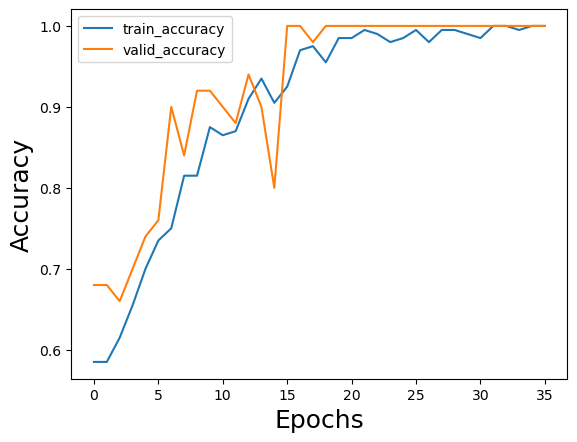

In [43]:
plt.plot(accs_train, label="train_accuracy")
plt.plot(accs_valid, label="valid_accuracy")
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend()
plt.savefig('vgg16_gap_accuracy_curve.png')
plt.show()

### 損失曲線

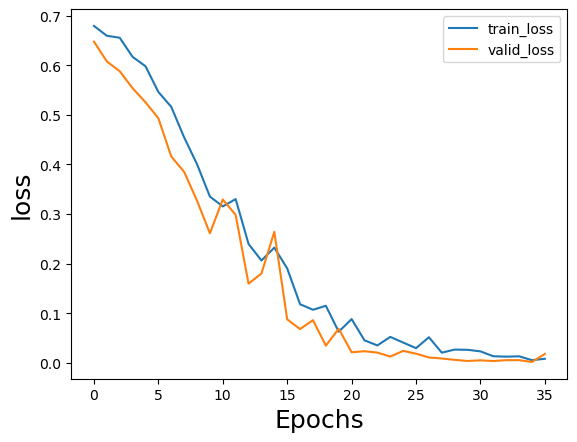

In [44]:
plt.plot(losses_train, label="train_loss")
plt.plot(losses_valid, label="valid_loss")
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.legend()
plt.savefig('vgg16_gap_loss_curve.png')
plt.show()

### 保存したベストな重みをロードし、推論モードにする

In [45]:
model_tuned.load_state_dict(torch.load('./vgg16_gap_checkpoint_model.pth', map_location=torch.device(device)))
model_tuned.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# ROC曲線

In [48]:
# 推論にかかる実行時間を計測
# start = torch.cuda.Event(enable_timing=True)
# end = torch.cuda.Event(enable_timing=True)

In [50]:
def tentap2list(tentap):
  """
  予測確率と勾配がタプルに格納されているリストから予測確率だけをリストに格納する関数
  """
  probas_list = [tentap[i].item() for i in range(len(tentap))]
  return probas_list

# 検証データに対する予測確率を保存する
target = []
probas = []
for x, t in dataloader_valid:
  x = x.to(device)
  t = t.to(device)
  # start.record()
  y = model_tuned.forward(x)
  # end.record()
  # torch.cuda.synchronize()
  # elapsed_time = start.elapsed_time(end)
  # print(f'GPU times: {elapsed_time / 1000} sec.')
  y = torch.squeeze(y)

  target += t
  probas += y

print(f"probas' length: {len(probas)}\ntarget's length: {len(target)}")

probas_list = tentap2list(probas)
targets_list = tentap2list(target)

targets_arr = np.array(targets_list)
probas_arr = np.array(probas_list)

probas_list = [round(probas_list[i], 4) for i in range(len(probas_list))]

preds = np.where(probas_arr>=0.5, 1.0, 0.0)
print(confusion_matrix(targets_list, preds))

probas' length: 50
target's length: 50
[[32  0]
 [ 0 18]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


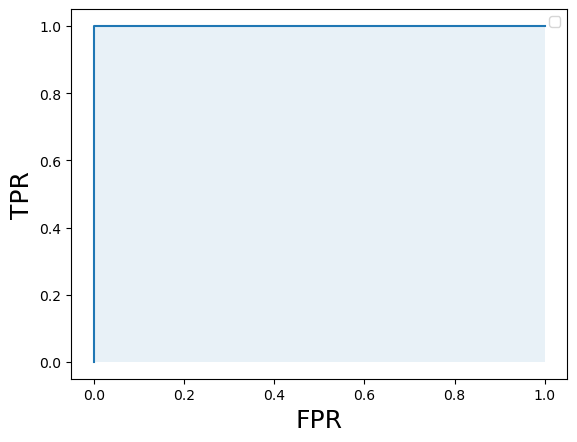

AUC: 1.0000


In [51]:
from sklearn.metrics import roc_curve, roc_auc_score
targets_arr = np.array(targets_list)
probas_arr = np.array(probas_list)
fpr, tpr, thresholds = roc_curve(y_true=targets_arr, y_score=probas_arr, pos_label=1)
plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, 0, alpha=0.1)

plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.legend()
# plt.savefig('../outputs/vgg16_gap/roc_curve.png')
plt.show()
print(f'AUC: {roc_auc_score(targets_list, probas_list):.4f}')

# テストデータに対する推論

In [52]:
t_preds = []
for x in dataloader_test:
  x = x.to(device)
  output = model_tuned(x)
  pred = torch.squeeze((output>=0.5).float().int()).to('cpu').numpy()
  t_preds.extend(pred)

In [53]:
submission = pd.DataFrame({"id": x_test, "pred": t_preds})
submission.head()

,id,pred
0,19871.jpeg,1
1,29934.jpeg,1
2,39826.jpeg,1
3,49888.jpeg,0
4,59918.jpeg,1


In [54]:
# submission.to_csv('/content/drive/MyDrive/university/seminar/chuzo-pj/outputs/Jun4_vgg16_gap_input300_valLoss00359_auc100.csv', index=None, header=None)

## Grad CAM

In [55]:
def PlotGradCam(model, img_path):
  features = model.features.eval()
  avgpool = model.avgpool.eval()
  classifier = model.classifier.eval()
  
  normalize = transforms.Normalize(
      mean=[0.4834, 0.4834, 0.4834],
      std=[0.2892, 0.2892, 0.2892])

  preprocess = transforms.Compose([
      transforms.Resize(300),
      transforms.CenterCrop(300),
      transforms.ToTensor(),
      normalize
  ])
  img = Image.open(img_path)
  img_tensor = preprocess(img)

  feature = features(img_tensor.view(-1,3,300,300))
  feature = feature.clone().detach().requires_grad_(True)

  pooled = avgpool(feature)

  y_pred = classifier(pooled.view(-1, 512))
  pred_index = torch.argmax(y_pred)
  y_pred[0][pred_index].backward()

  feature_vec = feature.grad.view(512, 9*9)
  feature = feature.squeeze(0)
  alpha = torch.mean(feature_vec, axis=1)

  L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0))
  L = L.detach().numpy()

  L_min = np.min(L)
  L_max = np.max(L - L_min)
  L = (L - L_min) / L_max

  # 元画像と同じサイズにリサイズする
  L = cv2.resize(L, (300, 300))

  # heat map に変換
  def toHeatmap(x):
      x = (x*255).reshape(-1)
      cm = plt.get_cmap('jet')
      x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
      return x.reshape(300,300,3)

  img2 = toHeatmap(L)
  img1 = img_tensor.squeeze(0).permute(1,2,0)

  alpha = 0.5
  grad_cam_image = img1*alpha + img2*(1-alpha)

  plt.imshow(grad_cam_image)
  #plt.savefig('def_133_scratch.png')

In [58]:
model_tuned = models.vgg16(pretrained=True)

#for param in model_tuned.parameters():
#        param.requires_grad = False

model_tuned.avgpool = GAP()
in_dim = 512
out_dim = 1
model_tuned.classifier = nn.Sequential(
    nn.Linear(in_dim, 256),
    nn.ReLU(True),
    nn.Dropout(p=0.2),
    nn.Linear(256, 64),
    nn.ReLU(True),
    nn.Dropout(p=0.2),
    nn.Linear(64, out_dim),
    nn.Sigmoid(),
)
model_tuned.classifier.apply(init_weights)
model_tuned.to('cpu')
model_tuned.load_state_dict(torch.load('./vgg16_gap_checkpoint_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


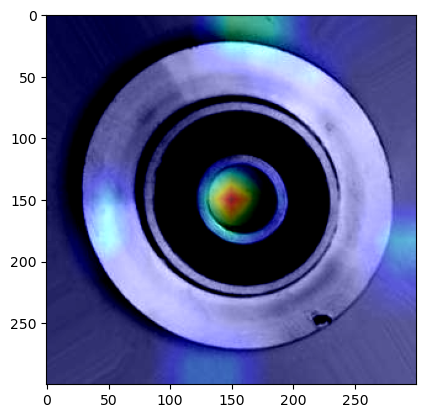

In [59]:
img_path = TrainImg_DIR + 'cast_def_0_133.jpeg'
PlotGradCam(model_tuned, img_path)